In [ ]:
import csv
path = "/content/sabpatch_parsed_folders.csv"
dictionary_train = {}
with open(path, mode ='r')as file:
  csvFile = csv.reader(file)
  i = 0;
  for lines in csvFile:
        if(i != 0):
          dictionary_train[lines[0]] = int(lines[3])
        i += 1
dictionary_test = {}
path = "/content/sabpatch_parsed_test.csv"
with open(path, mode ='r')as file:
  csvFile = csv.reader(file)
  i = 0;
  for lines in csvFile:
        if(i != 0):
          dictionary_test[lines[0]] = int(lines[3])
        i += 1

In [ ]:
len(dictionary_test)

627

2 csv files have been uploaded to this notebook. I parsed them to create a map between the image names and their respective labels.

In [ ]:

import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd

cudnn.benchmark = True
plt.ion()

In [ ]:
class CancerDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        #Since the labels are in the 4th column
        label = int(self.annotations.iloc[idx, 3])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/images'


In [ ]:
num_classes = 3
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [ ]:
dataset = CancerDataset(csv_file='/content/sabpatch_parsed_folders.csv', root_dir= data_dir, transform=data_transforms['train'])

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = CancerDataset(csv_file='/content/sabpatch_parsed_test.csv', root_dir= data_dir, transform=data_transforms['train'])


In [ ]:
len(train_dataset), len(val_dataset)

(2508, 628)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

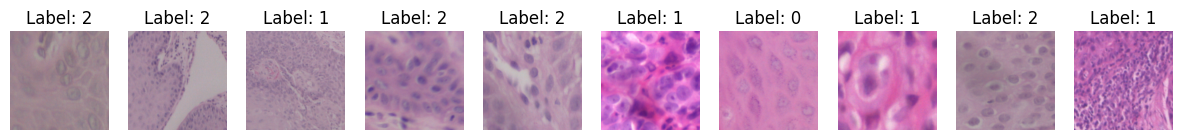

In [ ]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # The reverse of (tensor - mean) / std
    return tensor

# Display a few images from the training set
def show_images(dataloader, num_images):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # Using the built-in `next` function
    images = images[:num_images]
    labels = labels[:num_images]

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image = images[i]
        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0).numpy()
        label = labels[i].item()

        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.show()

# Show images from the training set
show_images(train_loader, num_images=10)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)

# Modifying the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.9815 Acc: 0.5518
val Loss: 0.8942 Acc: 0.5318
Epoch 2/10
----------
train Loss: 0.8232 Acc: 0.6057
val Loss: 0.8647 Acc: 0.5541
Epoch 3/10
----------
train Loss: 0.7880 Acc: 0.6312
val Loss: 0.7870 Acc: 0.6258
Epoch 4/10
----------
train Loss: 0.7579 Acc: 0.6463
val Loss: 0.7955 Acc: 0.6178
Epoch 5/10
----------
train Loss: 0.7414 Acc: 0.6515
val Loss: 0.7556 Acc: 0.6274
Epoch 6/10
----------
train Loss: 0.7293 Acc: 0.6627
val Loss: 0.8675 Acc: 0.6306
Epoch 7/10
----------
train Loss: 0.7080 Acc: 0.6591
val Loss: 0.7651 Acc: 0.6178
Epoch 8/10
----------
train Loss: 0.7062 Acc: 0.6842
val Loss: 0.8316 Acc: 0.6545
Epoch 9/10
----------
train Loss: 0.6896 Acc: 0.6770
val Loss: 0.7754 Acc: 0.6115
Epoch 10/10
----------
train Loss: 0.7081 Acc: 0.6766
val Loss: 1.2930 Acc: 0.6099


In [ ]:
torch.save(model.state_dict(), 'cancer_classification_resnet50.pth')

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
evaluate_model(model, test_loader)

Test Accuracy: 0.6093
